# Vignettes

Plot figures for selected vignettes.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm

import sys
sys.path.append("/scratch/dyl3pc/BPNet/retina-models/src")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

2022-05-04 11:44:35.519915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/scratch/dyl3pc/Clint/resources/hg38_UCSC.fa")

In [5]:
models = defaultdict(dict)
ctypes = [os.path.basename(dir_) for dir_ in glob.glob("/scratch/dyl3pc/BPNet/output/pos_regions/*")]
FOLDS = [1,2,3,4,5]
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for ctype in ctypes:
        for fold in FOLDS:
            models[ctype][fold] = tf.keras.models.load_model(f"/scratch/dyl3pc/BPNet/output/model/{ctype}/fold{fold}.h5")

2022-05-04 11:45:13.227221: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-04 11:45:13.308793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-05-04 11:45:13.308836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-04 11:45:13.609656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-04 11:45:13.609743: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-04 11:45:13.802837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
202

In [6]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in FOLDS:
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [7]:
INP_LEN = models[ctypes[0]][1].input_shape[1]
OUT_LEN = models[ctypes[0]][1].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

## Load SNPs

In [8]:
snp_lists = dict()

for x in glob.glob("/scratch/dyl3pc/BPNet/external_resources/*"):
    set_name = os.path.basename(x).split('.')[0]
    
    snp_lists[set_name] = pd.read_csv(x,
                       sep='\t',
                      names=['chr', 'start', 'rs', 'ref', 'alt'])

In [9]:
BUFFER = 500 # to adjust for indels

ref_one_hots = defaultdict(list)
alt_one_hots = defaultdict(list)

for x in snp_lists:
#     print(x)
    for _, y in snp_lists[x].iterrows():
        ref_one_hots[x].append(str(hg38[y['chr']][(y['start'] - INP_LEN//2):(y['start'] + INP_LEN//2 + BUFFER)]))
        
        # correct those that don't match ref as per dataframe
        if ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] != y['ref']:
            ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN//2 - 1] + y['ref'] + ref_one_hots[x][-1][INP_LEN//2 - 1 + len(y['ref']):]
            assert(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])] == y['ref'])
#             print(ref_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['ref'])], y['ref'], y['alt'])
        
        cur_alt = ref_one_hots[x][-1]
        cur_alt = cur_alt[:INP_LEN//2 - 1] + y['alt'] + cur_alt[INP_LEN//2 -1 + len(y['ref']):]
        alt_one_hots[x].append(cur_alt)
        assert(alt_one_hots[x][-1][INP_LEN//2 - 1:][:len(y['alt'])] == y['alt'])
        
        # trim to model input length
        ref_one_hots[x][-1] = ref_one_hots[x][-1][:INP_LEN]
        alt_one_hots[x][-1] = alt_one_hots[x][-1][:INP_LEN]

    ref_one_hots[x] = one_hot.dna_to_one_hot(ref_one_hots[x])
    alt_one_hots[x] = one_hot.dna_to_one_hot(alt_one_hots[x])

## Plotting Code

In [10]:
def plot_rsid(rsid, celltype, shap_window=100, title=None):
    
    EXAMPLE_IDX = snp_lists['CAD'][snp_lists['CAD']['rs'] == rsid].index[0]
    
    cur_raw_seqs = np.vstack([ref_one_hots['CAD'][EXAMPLE_IDX:EXAMPLE_IDX+1], 
                          alt_one_hots['CAD'][EXAMPLE_IDX:EXAMPLE_IDX+1]])
    
    # collapse predited profile across folds
    preds = np.array([get_profile(models[celltype][i].predict(cur_raw_seqs)) for i in FOLDS]).mean(0)
    
    counts_shap_scores = np.array([model_count_explainers[celltype][i].shap_values(cur_raw_seqs) for i in FOLDS]).mean(0)
    projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)
    
    ymin = np.min(projected_shap_scores)
    ymax = np.max(projected_shap_scores) + 0.02

    fig, ax = plt.subplots(3, figsize=(20,6))

    ref_avg_prof = preds[0]
    alt_avg_prof = preds[1]

    ax[0].plot(ref_avg_prof, label='ref ({})'.format(snp_lists['CAD'].iloc[EXAMPLE_IDX]['ref']))
    ax[0].plot(alt_avg_prof, label='alt ({})'.format(snp_lists['CAD'].iloc[EXAMPLE_IDX]['alt']))
    ax[0].legend()

    SLICE_START = INP_LEN//2 - shap_window//2
    SLICE_END = INP_LEN//2 + shap_window//2


    ax[1].vlines(INP_LEN//2-1 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')
    ax[2].vlines(INP_LEN//2-1 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')

    logomaker.Logo(pd.DataFrame(projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[1])
    logomaker.Logo(pd.DataFrame(projected_shap_scores[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
                  ax=ax[2])


    ax[1].set_ylim(ymin, ymax)
    ax[2].set_ylim(ymin, ymax)
    fig.suptitle("{} ({})".format(celltype, snp_lists['CAD'].iloc[EXAMPLE_IDX]['rs']))
    
    return fig

## SMAD3 

In [11]:
snp_lists['CAD'].loc[snp_lists['CAD']['rs']=="rs17293632"]

,chr,start,rs,ref,alt
2199,chr15,67150258,rs17293632,T,C


In [ ]:
for ctype in ctypes:
    fig = plot_rsid("rs17293632", ctype)

In [ ]:
non_causal_snps = ["rs72743461", "rs56375023", "rs17228058"]
import itertools
for snp, ctype in itertools.product(non_causal_snps, ctypes):
    fig = plot_rsid(snp, ctype)

## rs1874459

In [56]:
snp_lists['allRetina'].loc[snp_lists['allRetina']['rs']=="rs10858881"]

,chr,start,rs,ref,alt,isTier2,isTier3,isInPeaks
5866,chr16,65041801,rs1874459,G,C,True,True,True


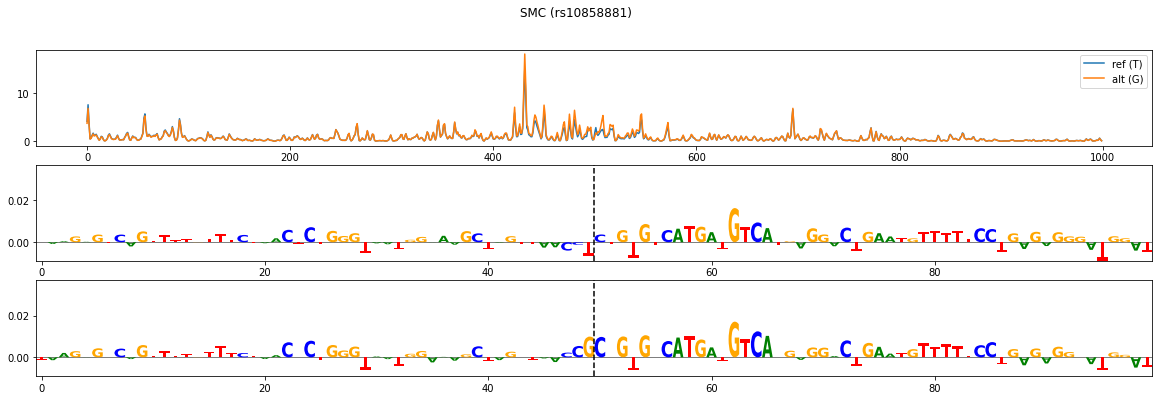

In [12]:
fig = plot_rsid("rs10858881", "SMC")

In [68]:
fig.savefig("plots/rs1874459.pdf")

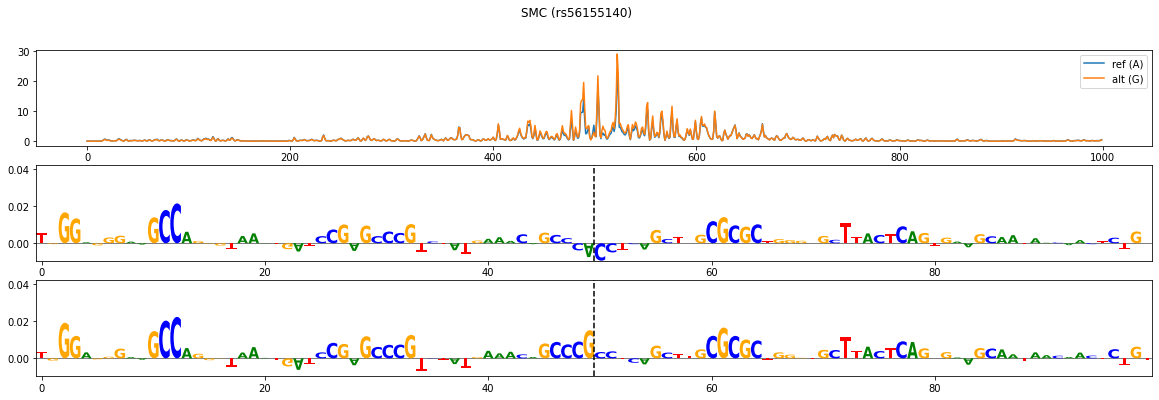

In [13]:
fig = plot_rsid("rs56155140", "SMC")

/nv/vol192/civeleklab/dillon/conda/shap/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-05-04 11:49:00.509442: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-04 11:49:02.675721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-05-04 11:49:05.762506: W tensorflow/stream_executor/gpu/asm_compiler.cc:64] Running ptxas --version returned 32512
2022-05-04 11:49:05.826072: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged o

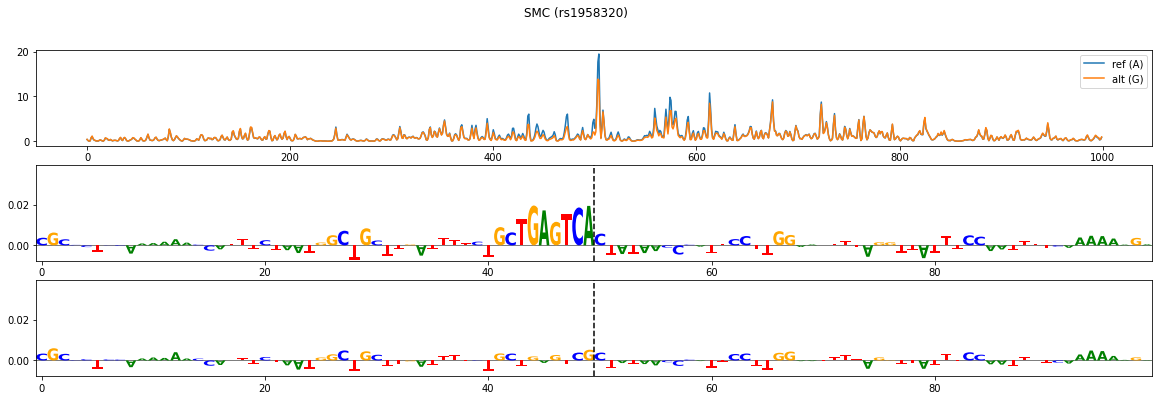

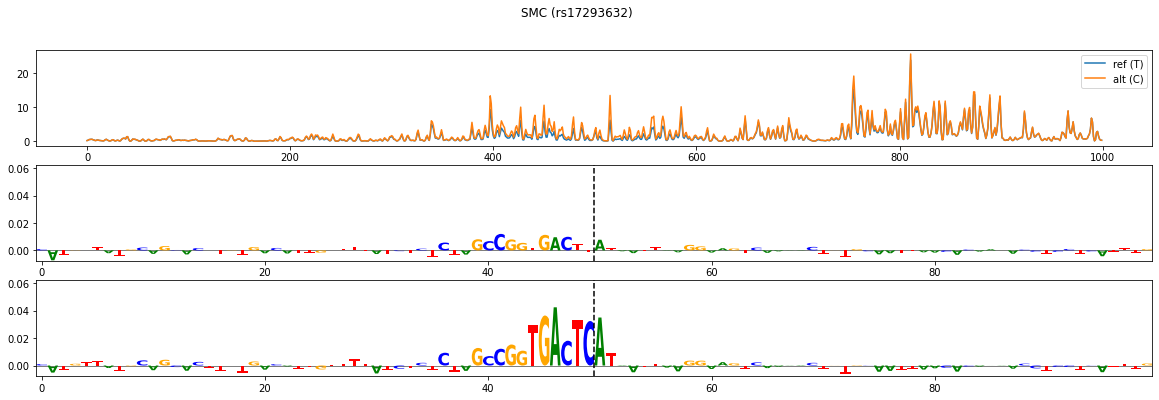

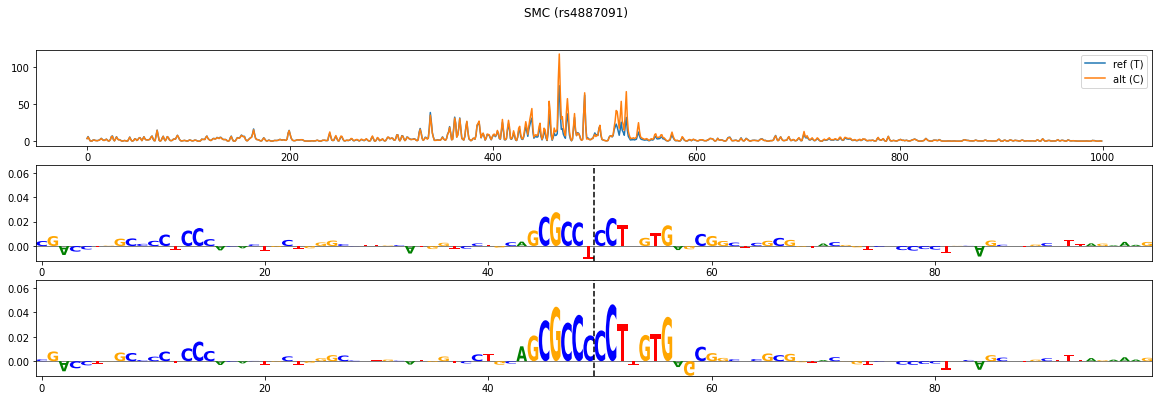

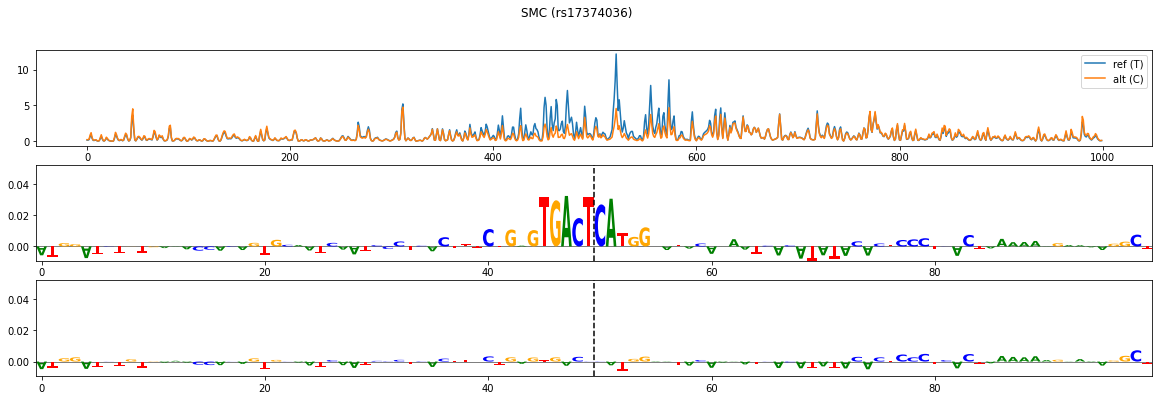

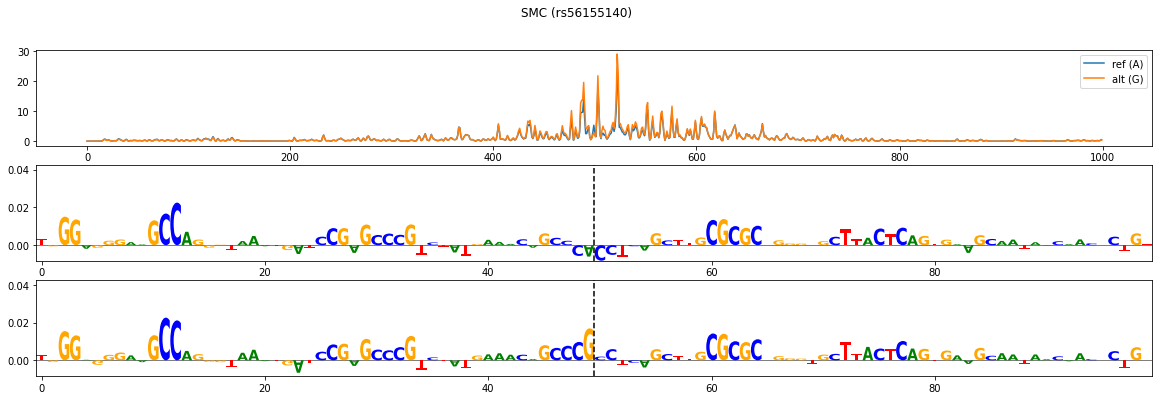

In [11]:
snps = """
rs1958320
rs17293632
rs4887091
rs17374036
rs56155140
""".strip().split()


for snp in snps:
    plot_rsid(snp, "SMC")